## **Research Question**

Can machine learning accurately predict customer churn in a telecom company using customer demographic, service usage and billing data, and what key factors contribute most to customer retention?

## **Libraries**

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

## **Data Preprocessing**

In [4]:
#Load the dataset
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
#Initial data exploration
print("Initial Data Preview:")
print(data.head())
print(data.info())
print(data.describe())

Initial Data Preview:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovie

In [6]:
#Handling missing values
data = data.drop(columns=['customerID'])

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

<ipython-input-6-955094d0354b>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [7]:
#Encoding categorical variables
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Churn':
        data[column] = LabelEncoder().fit_transform(data[column])

#Encoding the target variable
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
#Splitting data into training and testing sets
X = data.drop('Churn', axis=1)
y = data['Churn']

#Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## **Feature Scaling**

In [9]:
#Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Model Training**

In [10]:
#Model Building: Gradient Boosting Classifier with Hyperparameter Tuning
model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [11]:
#Best model from Grid Search
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

Best Model Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


## **Testing & Evaluation**

In [12]:
#Model Predictions
y_pred = best_model.predict(X_test)

In [13]:
#Model Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

roc_score = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_score:.2f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1021
           1       0.85      0.85      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070

Confusion Matrix:
[[858 163]
 [157 892]]
Accuracy: 0.85
ROC AUC Score: 0.85


## **Visualizations**

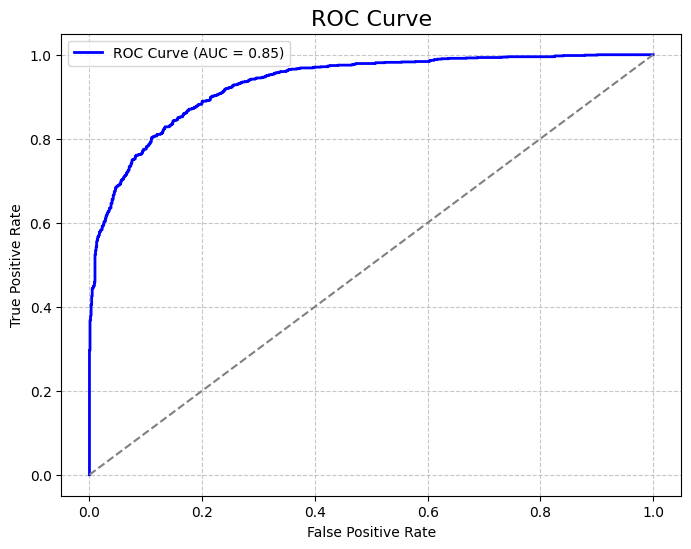

In [14]:
#ROC Curve
if hasattr(best_model, "predict_proba"):
    fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Model does not support probability predictions.")

<ipython-input-15-d88c9a8b5b37>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.nlargest(10), y=feature_importances.nlargest(10).index, palette='viridis')


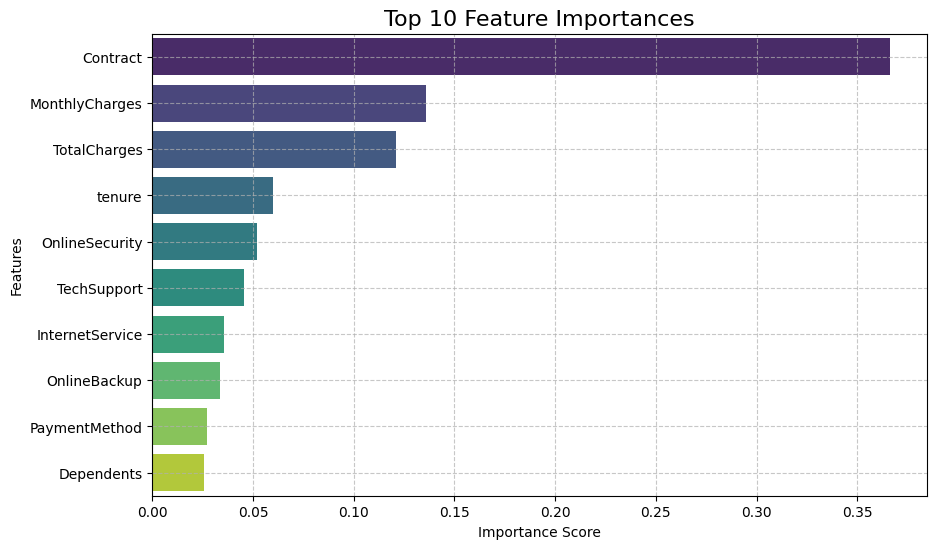

In [15]:
#Feature Importance
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.nlargest(10), y=feature_importances.nlargest(10).index, palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## **Analysis of Graphs and Model Performance**

### **Classification Report:**
The balanced precision and recall for both classes (0 and 1) demonstrate that the model is not biased towards a particular class which is very critical in churn prediction.

### **Confusion Matrix:**
* True Positives (892): Correctly predicted churners.
* True Negatives (858): Correctly predicted non-churners.
* False Positives (163): Predicted churn when there was none which could lead to unnecessary retention efforts.
* False Negatives (157): Missed predicting actual churners but this is significantly lower than before.

### **ROC Curve:**
The curve's steep rise indicates a high True Positive Rate (Recall) with a low False Positive Rate. This reflects a strong model performance.

### **Feature Importance:**
**Top 3 Features:**
* Contract Type: The most influential predictor of churn which suggests that the type of contract (eg, month-to-month,one-year, two-year) has a strong impact on customer retention.
* Monthly Charges: High charges are likely correlated with churn. This shows potential price sensitivity among customers.
* Total Charges: Even though it is important, its impact is slightly less than the monthly charges and contract type.

The prominence of Contract Type suggests that offering incentives for longer-term contracts could reduce churn. Additionally, analyzing price sensitivity could lead to better pricing strategies or bundled offers.


